# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Helper functions

> Following functions will be called as general purpose in more cells below

In [48]:
import csv
import pickle
import datetime
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
import math
import keras
from scipy.misc import imread
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from beautifultable import BeautifulTable
from tensorflow.contrib.layers import flatten
K.set_image_dim_ordering('th')

def Read_Data_From_Pickle(file_name):
    """
        This function read data from a pickle
            Input:
                file_name: pickle file name
            Return:
                Sampes, lables
    """
    with open(file_name, mode='rb') as f:
        train = pickle.load(f)
    return train['features'], train['labels']

def Write_Data_To_Pickle(data, file_name):
    """
        This function writes a data to pickle
            Input:
                data: data to write
                file_name:
    """
    pickle.dump( data, open( file_name, "wb" ) )

def Read_Csv(file_name, column_idx , delimiter):
    """
        This function reads a column from a csv file
            input: 
                file_name: name of the csv file
                column_idx: the index of the column to be read
                delimiter: column delimiter symbol
            return: a list of data
    """
    data = []
    with open(file_name, "r") as f:
        reader = csv.reader(f, delimiter=delimiter)
        for num,row in enumerate(reader):
            if num >= 1:
                data.append(row[column_idx])
    return data

def Calculate_Time_Diff_Up_To_Now_in_second(start_time):
    """
        This function calculate a time difference between a time point in the pass and now
            Input: 
                start_time: a time point in the pass
            return time difference in seconds
    """
    after  = datetime.datetime.now()
    return math.floor(((after - start_time).seconds))

def print_Table(header,data):
    """
        plot a table of data with a given header
            input param:
                header: 1D list
                data: 2D list
    """ 
    table_data = []
    number_rows = min(len(header),len(data))
    table = BeautifulTable(max_width=123)
    table.column_headers = header[0:number_rows:1]
    table_data = data[0:number_rows]  
    for n in range(len(table_data[0])):
        table.append_row([row[n] for row in table_data])
    print(table)

def Plot_Images(images, title = None):
    """
        This function plot an arbitrary number of images
            input: 
                images: a numpy array of images
                title: a title for the plot
    """
    image_number = len(images)
    fig, axs = plt.subplots(int(image_number / 5),5, figsize=(20, 4 * image_number/5))
    fig.suptitle(title, fontsize=18)
    axs = axs.ravel()    
    for n in range(image_number):
        axs[n].axis('off')
        if images[n].shape[2] == 1:
            axs[n].imshow(images[n].squeeze(), cmap='gray')
        else:
            axs[n].imshow(images[n])
    plt.show() 
    
def Plot_Curve(data, labels = None, title = None, xLabel = None, yLabel = None):
    """
        This function plots a curve diagram of datas
            Input: 
                data: a list of datas, where data[0] is on x-axis, the other elements are data on y-axis
                labels: a list of labels of datas
                title: tilte of the diagram
                xLable: label on x
                yLable: lable on y
    """
    plt.figure(figsize=(10,5))
    plt.ylabel(yLabel)
    plt.xlabel(xLabel)
    plt.title(title)
    for i in range(1,len(data)):
        plt.plot(data[0], data[i],label = labels[i - 1])
    plt.legend()
    plt.show()    
    
def Data_Visualisation(labels,class_name):
    """
        This function visualizes a given data set
            input:
                labels: data set to be visualized
                class_name: name of classes of the data set
    """
    number_samples = []
    table_Data = []
    for i in range(len(labels)):
        img = number_of_labels_per_class(labels[i])
        number_samples.append(img)
    header = ["labels", "Training", "Test", "Validation", "Class name" ]
    # visualize data in a table
    x = [i for i in range(len(class_name))]
    table_Data.append(x)
    table_Data = table_Data + number_samples
    table_Data.append(class_name)
    print_Table(header,table_Data)
    # Barchart
    width = 0.3
    index = np.array(len(class_name))
    plt.figure(figsize=(20,10))
    plt.ylabel('number of samples')
    plt.xlabel('labels')
    plt.title('data sets')
    x = np.array(x)
    p0=plt.bar(x - width, number_samples[0], width = width, color='g', label = "training")
    p1=plt.bar(x, number_samples[1], width = width, color='b', label = "test")
    p2=plt.bar(x + width, number_samples[2], width = width, color='r', label = "validation")
    plt.legend((p0[0], p1[0], p2[0]), ('train' , 'test', 'validation'))
    plt.show()
    
def Get_and_crop_n_image_randomly(images, number_Signs, labels):
    """
        This function extracts a number of images from a given image set
            input:
                images: a numpy array of images
                number_Signs: number of images to extract
                labels: labels of input image set
            return: a list of images
    """
    cropped_images = []
    chosen_labels = []
    # Get n signs randomly from the test set
    indices = random.sample(range(0,len(images)),number_Signs) 
    # Read and crop images
    for n in range(0,number_Signs):
        img = imread(images[indices[n]])
        resized_image = cv2.resize(img,(32,32))
        cropped_images.append(resized_image)
        chosen_labels.append(labels[indices[n]])
    return cropped_images, chosen_labels

def Get_n_images_randomly(images, number_images, labels, convert_to_array = False):
    chosen_images = []
    chosen_labels = []
    # Get n signs randomly from the test set
    indices = random.sample(range(0,len(images)),number_images)
    # Read and crop images
    for n in range(0,number_images):
        if convert_to_array == False:
            chosen_images.append(images[indices[n]])
        else: 
            chosen_images.append(img_to_array(images[indices[n]]))         
        chosen_labels.append(labels[indices[n]])
    return (chosen_images), (chosen_labels)
    
def number_of_class(labels):
    """
        This function returns the number of classes in a data set
    """
    return len(np.unique(labels))
            
def number_of_labels_per_class(labels):
    """
        This function counts number of samples per class of a data set
            input:
                labels: labels of the data set
            return: a list of number of samples of all classes
    """
    number_samples = []
    n_classes = number_of_class(labels)
    for n in range (n_classes):
        number_samples.append(np.count_nonzero(labels == n))
    return number_samples


def extract_data_Subset(X_train, Y_train, label):
    """
        This function extracts all samples of a class in a data set
            input: 
                X_train: training samples
                Y_train: training labels
                labels: label of the class, whose samples are being extracted
            return: a numpy array of all sample of the class
    """
    dataset_train = []
    for i in range(0, len(Y_train)):
        if Y_train[i] == label:
            img = img_to_array(X_train[i])
            dataset_train.append(img)
    return np.array(dataset_train)
    
def GenerateNewSubsetData(origin_Data, number_Generated_img, batch_size):
    """
        This function generates a new data subset from an input data
            input:
                origin_Data: input data as basic to generate new data
                number_Generated_img: number of images to generate
                batch_size: batch size
            return a set of modified images, which have the same content as the one of the 
                    original data set
    """
    generated_Images = []

    datagen = ImageDataGenerator(rotation_range=4, 
                                 width_shift_range=0.05, 
                                 height_shift_range=0.05, 
                                 zoom_range=0.05,
                                shear_range=0.05
                                )
    # fit parameters from data
    datagen.fit(origin_Data)

    X_batch = datagen.flow(origin_Data, batch_size=batch_size)
    for i, new_images in enumerate(X_batch):
        if i < number_Generated_img:
            new_image = array_to_img(new_images[0])
            new_image = np.array(new_image)
            generated_Images.append(new_image)
        else:
            break
    return generated_Images

def augment_brightness_1_image(image):
    """
        This function creates a new image by changing the brightness of the original image
            input:
                image: basic image to change brightness
            return: the modified image
    """
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def Image_Augmentation(Original_Dataset_Train, Original_Dataset_Labels):
    """
        This function augments a data set of images. 
        It generates new images by different methods, than add the new images to the original data set.
            input:
                Original_Dataset_Train: original data samples
                Original_Dataset_Labels: original data labels
            return: an augmented data set
    """
    result_Train = []
    result_labels = []
    # Brightness augmentation     
    brightness_augment = []
    for i in (Original_Dataset_Train):
        img = augment_brightness_1_image(i)
        brightness_augment.append(img)
    brightness_augment = np.array(brightness_augment)
    brightness_augment = Original_Dataset_Train
    # Other augmentation methods 
    # calculate number of classes
    n_class = number_of_class(Original_Dataset_Labels)
    # calculate number of samples per labels
    number_samples_per_class = number_of_labels_per_class(Original_Dataset_Labels)
    # calculate maximun number samples per a label
    max_sample_num = max(number_samples_per_class)
    #iterate over all labels
    for label in range(0,n_class):
        generated_labels = []
        extracted_Train = extract_data_Subset(brightness_augment, Original_Dataset_Labels, label)
        number_of_new_images = int((max_sample_num - number_samples_per_class[label]))
        if number_of_new_images > 0:
            generated_Train = GenerateNewSubsetData(extracted_Train, number_of_new_images, number_samples_per_class[label])
            generated_labels = [label] * number_of_new_images
            result_Train = result_Train + generated_Train
            result_labels = result_labels + generated_labels
    # concatenate the generated data to the original data
    result_Train = np.concatenate((Original_Dataset_Train,np.array(result_Train)), axis=0)
    result_labels = np.concatenate((Original_Dataset_Labels,np.array(result_labels)), axis=0)
    return shuffle(result_Train, result_labels)

def Convert_Data_To_GrayScale(data):
    """
        This function converts an image data set in grayscale
            input: 
                data: input data set
            return: a numpy array of grayscale images
    """
    return np.sum(data/3, axis=3, keepdims=True)

def Data_Normalization(data):
    """
        This function normalises an image data set
            input:
                data: grayscale image data set
            return normalised images
    """
    return data/255 - 0.5

---
## Step 0: Load The Data

In [49]:
# read data from pickle files
X_train, y_train = Read_Data_From_Pickle('train.p')
X_valid, y_valid = Read_Data_From_Pickle('valid.p')
X_test, y_test = Read_Data_From_Pickle('test.p')

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [50]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

+--------+----------+------+------------+---------------------------------------------------------------------------------+
| labels | Training | Test | Validation |                                   Class name                                    |
+--------+----------+------+------------+---------------------------------------------------------------------------------+
|   0    |   180    |  60  |     30     |                              Speed limit (20km/h)                               |
+--------+----------+------+------------+---------------------------------------------------------------------------------+
|   1    |   1980   | 720  |    240     |                              Speed limit (30km/h)                               |
+--------+----------+------+------------+---------------------------------------------------------------------------------+
|   2    |   2010   | 750  |    240     |                              Speed limit (50km/h)                               |
+-------

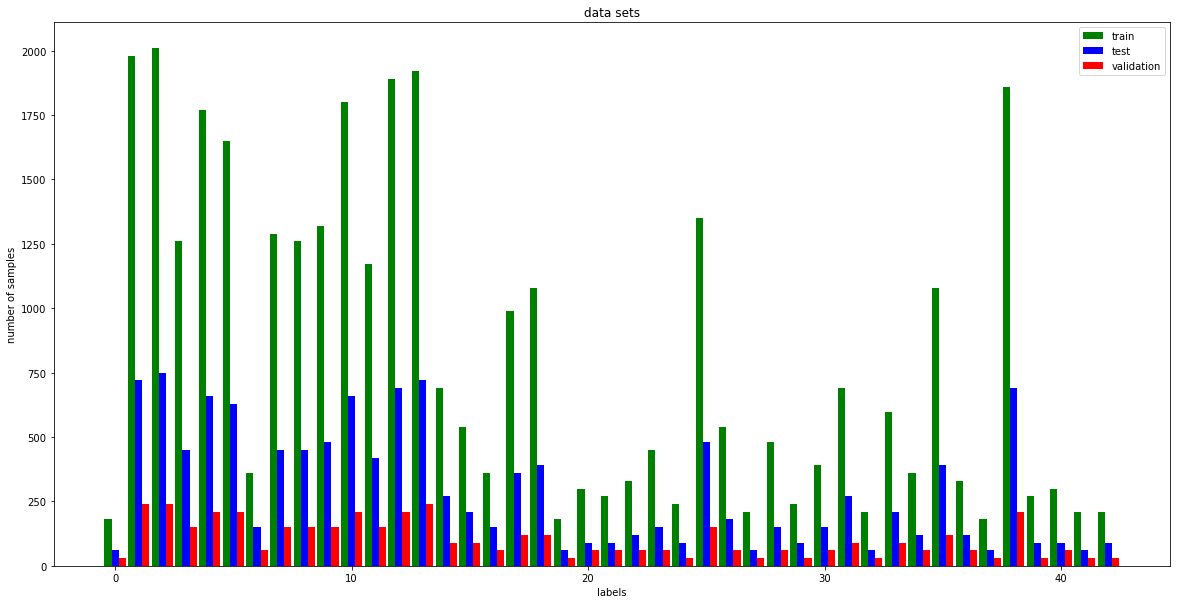

In [51]:
# Read csv data      
SignName_SvcFileName = './signnames.csv'
sign_names = Read_Csv(SignName_SvcFileName, 1, ',')
# visualize the original data set
Data_Visualisation([y_train,y_test,y_valid], sign_names)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

##### Pre-processing steps:
* Image augmentation
    * Brightness augmentation
    * Random augmentation with difference methods (e.g. transforming, sheering, rotating, etc.)
    * Shuffle data
* Convert data set to grayscale
* Data normalization

###### Demostration of pre-processing techniques

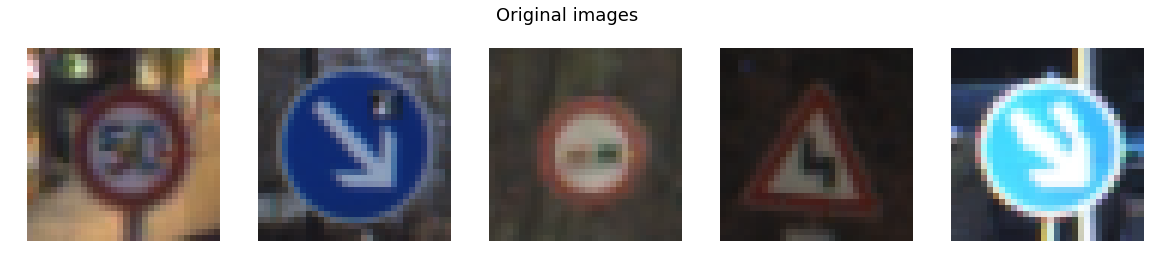

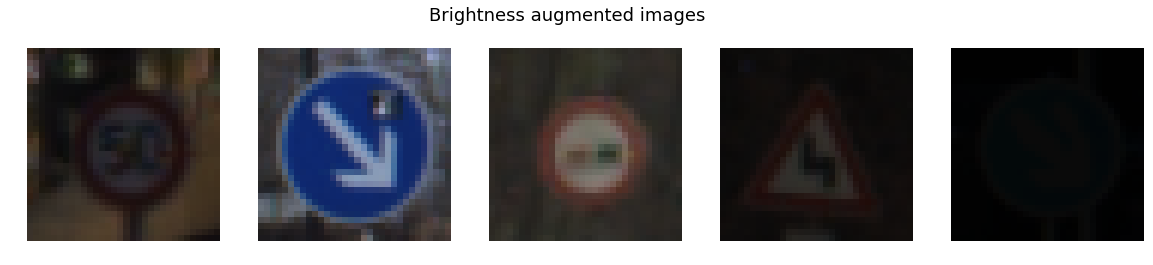

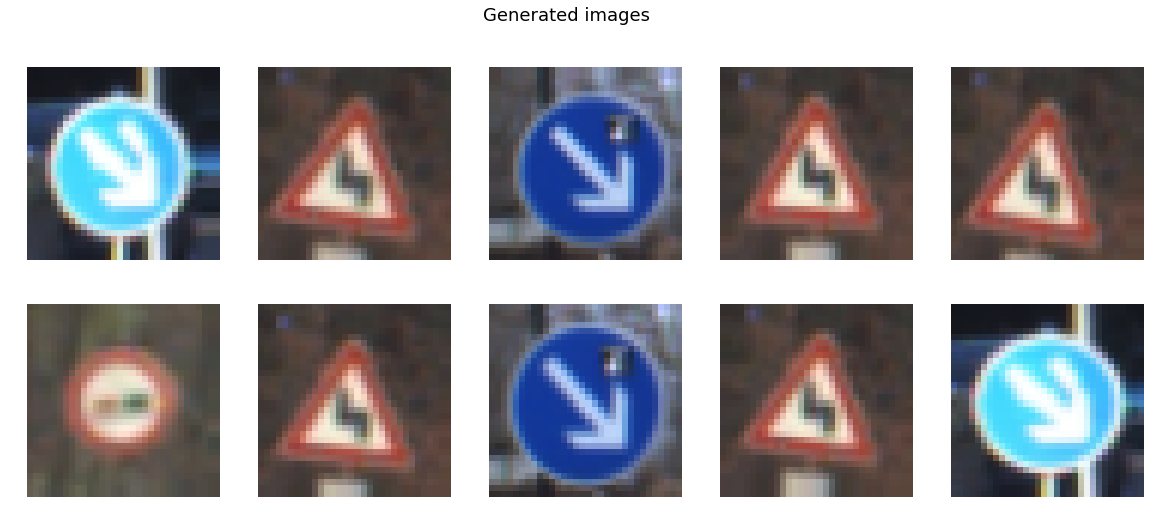

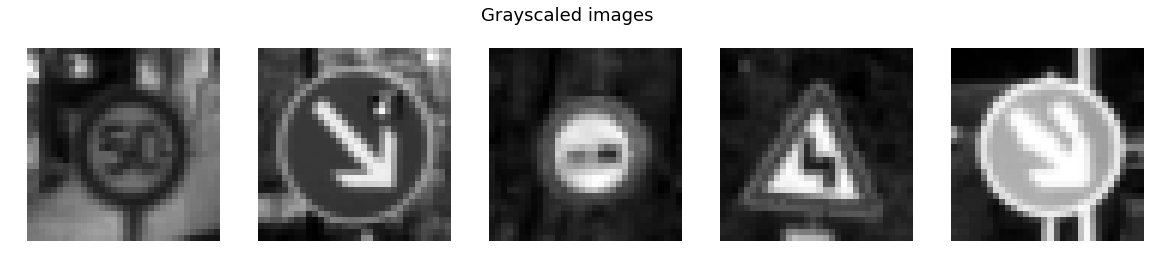

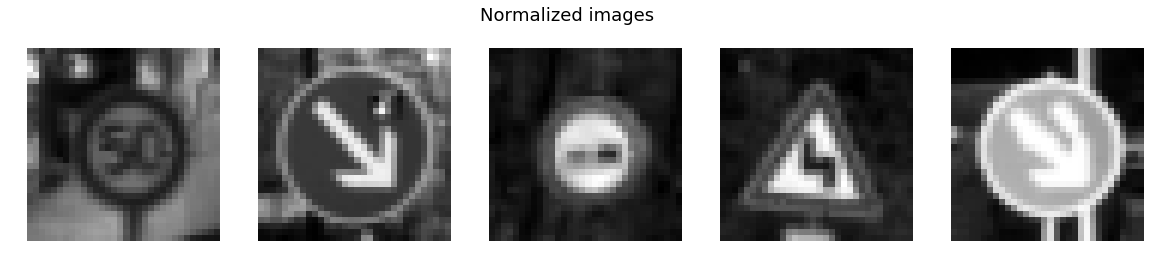

In [52]:
number_of_example_img = 5
# example images
example_images, example_labels = Get_n_images_randomly(X_train, number_of_example_img, y_train)
Plot_Images((np.array(example_images)), 'Original images')
preprocessed_images = []
# Brightness augmentation
for image in example_images:
    preprocessed_images.append(augment_brightness_1_image(image))
Plot_Images(preprocessed_images, 'Brightness augmented images')
# generate images
converted_img = []
for img in example_images:
    converted_img.append(img_to_array(img))
preprocessed_images = np.array(GenerateNewSubsetData(np.array(converted_img), 10, 10))
Plot_Images(preprocessed_images, 'Generated images')
# Grayscale conversion
preprocessed_images = Convert_Data_To_GrayScale(np.array(example_images))
Plot_Images(preprocessed_images, 'Grayscaled images')
# Normlisation
preprocessed_images = Data_Normalization(preprocessed_images)
Plot_Images(preprocessed_images, 'Normalized images')

+--------+----------+------+------------+---------------------------------------------------------------------------------+
| labels | Training | Test | Validation |                                   Class name                                    |
+--------+----------+------+------------+---------------------------------------------------------------------------------+
|   0    |   2010   |  60  |     30     |                              Speed limit (20km/h)                               |
+--------+----------+------+------------+---------------------------------------------------------------------------------+
|   1    |   2010   | 720  |    240     |                              Speed limit (30km/h)                               |
+--------+----------+------+------------+---------------------------------------------------------------------------------+
|   2    |   2010   | 750  |    240     |                              Speed limit (50km/h)                               |
+-------

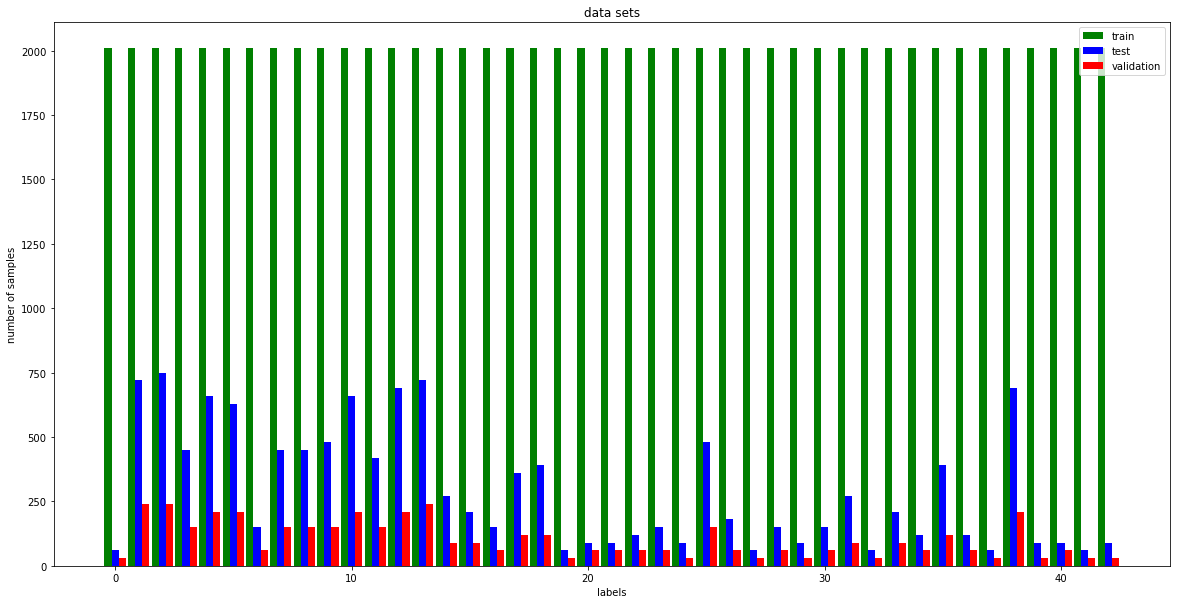

Augmentation time:  11349  seconds


In [22]:
Augmentation_start_time = datetime.datetime.now()
# augment the data set
X_train, y_train = Image_Augmentation(X_train, y_train)
# visualize augmented data
Data_Visualisation([y_train, y_test, y_valid], sign_names)

# convert the data set to grayscale
X_train = Convert_Data_To_GrayScale(X_train)
X_test = Convert_Data_To_GrayScale(X_test)
X_valid = Convert_Data_To_GrayScale(X_valid)

# Normalize the grayscale data set
X_train = Data_Normalization(X_train)
X_test = Data_Normalization(X_test)
X_valid = Data_Normalization(X_valid)
print("Augmentation time: ", Calculate_Time_Diff_Up_To_Now_in_second(Augmentation_start_time), " seconds")

#### Save augmented data

In [24]:
Write_Data_To_Pickle({"features":X_train,"labels":y_train}, "PreprocessedTrainData.p")
Write_Data_To_Pickle({"features":X_valid,"labels":y_valid}, "PreprocessedValidationData.p")
Write_Data_To_Pickle({"features":X_test,"labels":y_test}, "PreprocessedTestData.p")

#### Load pre-processed image data

In [4]:
X_train, y_train = Read_Data_From_Pickle('PreprocessedTrainData.p')
X_valid, y_valid = Read_Data_From_Pickle('PreprocessedValidationData.p')
X_test, y_test = Read_Data_From_Pickle('PreprocessedTestData.p')

### Model Architecture

#### Parameters

In [19]:
EPOCHS = 300
BATCH_SIZE = 128
mu = 0
sigma = 0.1
number_ouput_class = 43
number_channels = 1

#### Architecture

In [20]:
def LeNet(x, mu, sigma, number_channels, number_ouput_class):    
    
    # Layer 1: Convolutional. Input = 32x32xnumber_channels. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, number_channels, 6), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)

    # Activation.
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer1 = x
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x
    
    # Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma))
    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    b3 = tf.Variable(tf.zeros(400))
    x = tf.nn.bias_add(x, b3)
                     
    # Activation.
    x = tf.nn.relu(x)
    layer3 = x

    # Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    
    # Flatten x. Input = 1x1x400. Output = 400.
    xflat = flatten(x)
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([xflat, layer2flat], 1)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # Layer 4: Fully Connected. Input = 800. Output = number_ouput_class.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, number_ouput_class), mean = mu, stddev = sigma))
    b4 = tf.Variable(tf.zeros(number_ouput_class))    
    logits = tf.add(tf.matmul(x, W4), b4)
    
    return logits

#### Features and Labels

In [21]:
x = tf.placeholder(tf.float32, (None, 32, 32, number_channels))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32) # probability to keep units
one_hot_y = tf.one_hot(y, number_ouput_class)

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

#### Training pipeline

In [22]:
rate = 0.0009

logits = LeNet(x,mu,sigma, number_channels, number_ouput_class)
prediction = tf.argmax(logits, 1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [23]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

#### Train the model

Training...

EPOCH 1 ...Validation accuracy = 0.818...training time: 6 s

EPOCH 2 ...Validation accuracy = 0.907...training time: 7 s

EPOCH 3 ...Validation accuracy = 0.918...training time: 7 s

EPOCH 4 ...Validation accuracy = 0.932...training time: 6 s

EPOCH 5 ...Validation accuracy = 0.932...training time: 6 s

EPOCH 6 ...Validation accuracy = 0.934...training time: 7 s

EPOCH 7 ...Validation accuracy = 0.933...training time: 7 s

EPOCH 8 ...Validation accuracy = 0.950...training time: 6 s

EPOCH 9 ...Validation accuracy = 0.947...training time: 7 s

EPOCH 10 ...Validation accuracy = 0.951...training time: 6 s

EPOCH 11 ...Validation accuracy = 0.944...training time: 6 s

EPOCH 12 ...Validation accuracy = 0.963...training time: 6 s

EPOCH 13 ...Validation accuracy = 0.949...training time: 6 s

EPOCH 14 ...Validation accuracy = 0.955...training time: 6 s

EPOCH 15 ...Validation accuracy = 0.949...training time: 6 s

EPOCH 16 ...Validation accuracy = 0.949...training time: 6 s

EPOC

EPOCH 133 ...Validation accuracy = 0.967...training time: 6 s

EPOCH 134 ...Validation accuracy = 0.965...training time: 6 s

EPOCH 135 ...Validation accuracy = 0.968...training time: 6 s

EPOCH 136 ...Validation accuracy = 0.957...training time: 6 s

EPOCH 137 ...Validation accuracy = 0.967...training time: 6 s

EPOCH 138 ...Validation accuracy = 0.966...training time: 6 s

EPOCH 139 ...Validation accuracy = 0.968...training time: 6 s

EPOCH 140 ...Validation accuracy = 0.972...training time: 6 s

EPOCH 141 ...Validation accuracy = 0.964...training time: 6 s

EPOCH 142 ...Validation accuracy = 0.964...training time: 6 s

EPOCH 143 ...Validation accuracy = 0.966...training time: 6 s

EPOCH 144 ...Validation accuracy = 0.965...training time: 6 s

EPOCH 145 ...Validation accuracy = 0.969...training time: 6 s

EPOCH 146 ...Validation accuracy = 0.961...training time: 6 s

EPOCH 147 ...Validation accuracy = 0.957...training time: 6 s

EPOCH 148 ...Validation accuracy = 0.971...training tim

EPOCH 264 ...Validation accuracy = 0.968...training time: 6 s

EPOCH 265 ...Validation accuracy = 0.962...training time: 5 s

EPOCH 266 ...Validation accuracy = 0.971...training time: 5 s

EPOCH 267 ...Validation accuracy = 0.963...training time: 6 s

EPOCH 268 ...Validation accuracy = 0.957...training time: 6 s

EPOCH 269 ...Validation accuracy = 0.969...training time: 6 s

EPOCH 270 ...Validation accuracy = 0.967...training time: 6 s

EPOCH 271 ...Validation accuracy = 0.965...training time: 6 s

EPOCH 272 ...Validation accuracy = 0.967...training time: 5 s

EPOCH 273 ...Validation accuracy = 0.963...training time: 6 s

EPOCH 274 ...Validation accuracy = 0.965...training time: 5 s

EPOCH 275 ...Validation accuracy = 0.969...training time: 6 s

EPOCH 276 ...Validation accuracy = 0.971...training time: 6 s

EPOCH 277 ...Validation accuracy = 0.970...training time: 6 s

EPOCH 278 ...Validation accuracy = 0.956...training time: 6 s

EPOCH 279 ...Validation accuracy = 0.965...training tim

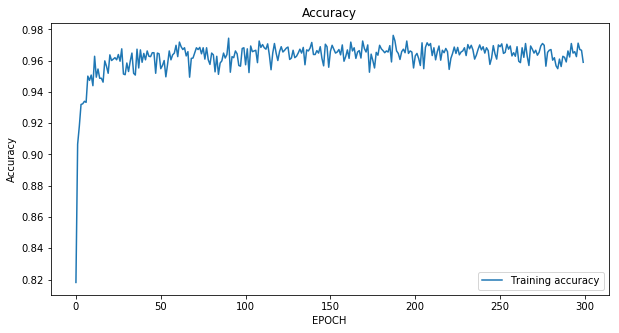

In [24]:
before = datetime.datetime.now()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    validation_accuracy_figure = []
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        epoch_start_time = datetime.datetime.now()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        validation_accuracy_figure.append(validation_accuracy)
        epoch_training_time = Calculate_Time_Diff_Up_To_Now_in_second(epoch_start_time)
        print("EPOCH {} ...Validation accuracy = {:.3f}...training time: {} s"
              .format(i+1, validation_accuracy, epoch_training_time))
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")
# Calculate the training time               
print("Training time: ", Calculate_Time_Diff_Up_To_Now_in_second(before), " seconds")
# Plot accuracies on a diagram
plot_data = []
plot_data.append([i for i in range (0,EPOCHS)])
plot_data.append(validation_accuracy_figure)
labels = ['Training accuracy', 'Validation accuracy']
Plot_Curve(plot_data, labels, title = "Accuracy", xLabel = "EPOCH", yLabel = "Accuracy")

#### Evaluate model

In [25]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.950


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

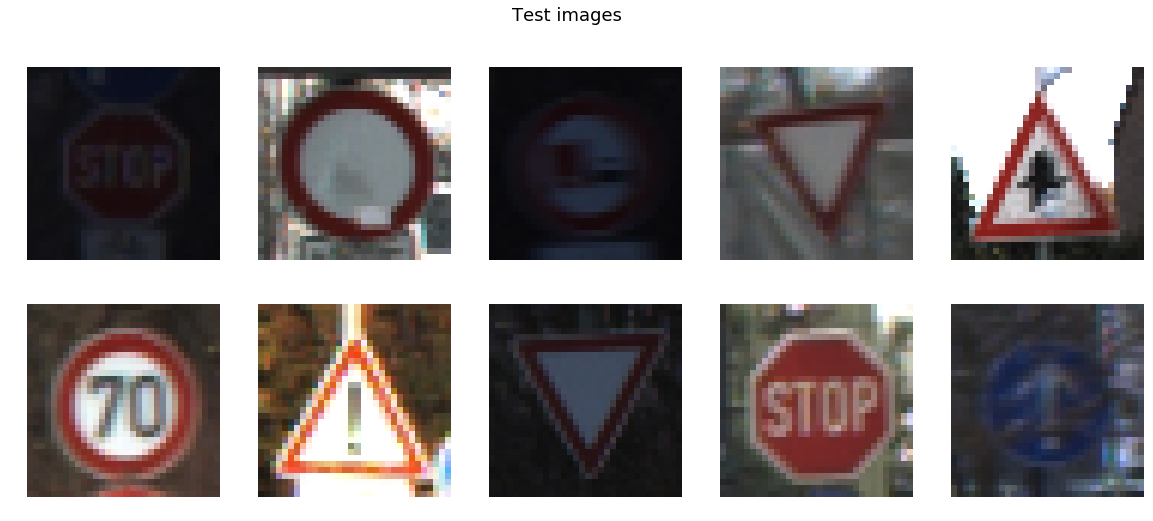

In [42]:
# Number of images to load
number_Signs = 10

# Read file names from germman traffic sign test set
dirName ='./GTSRB/Final_Test/Images'
# Read image file names
images = glob.glob(dirName + '/*.ppm')
# Read the corresponding labels
SignName_SvcFileName = './GTSRB/Final_Test/GT-final_test.csv'
sign_labels_in_test = Read_Csv(SignName_SvcFileName, 7, ';')
# get randomly images from the data set
read_images, read_labels = Get_and_crop_n_image_randomly(images, number_Signs, sign_labels_in_test)
Plot_Images(read_images, 'Test images')
# Convert the read images to grayscale
image_gry = Convert_Data_To_GrayScale(np.array(read_images))

### Predict the Sign Type for Each Image

In [43]:
# predict the read images
logit = []
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    logit = sess.run(prediction, feed_dict={x: image_gry, keep_prob: 1.0})
    
# visualise the read images and prediction results
header = ["Sign number", "predicted label", "annotation"]
sign_name = [sign_names[i] for i in logit]
table_Data = []
table_Data.extend([[i+1 for i in range(number_Signs)],logit,sign_name])
print_Table(header,table_Data)

INFO:tensorflow:Restoring parameters from .\lenet
+-------------+-----------------+-----------------------------------------------------------------------------------------+
| Sign number | predicted label |                                       annotation                                        |
+-------------+-----------------+-----------------------------------------------------------------------------------------+
|      1      |       14        |                                          Stop                                           |
+-------------+-----------------+-----------------------------------------------------------------------------------------+
|      2      |       15        |                                       No vehicles                                       |
+-------------+-----------------+-----------------------------------------------------------------------------------------+
|      3      |       10        |                      No passing for vehicles ove

### Analyze Performance

In [44]:
accuracy = 0.0
result = []
for n in range(number_Signs):
    if logit[n] == int(read_labels[n]):
        accuracy = accuracy + (100./number_Signs)
        result.append("correct")
    else:
        result.append("wrong")

print("Total accuracy = {} %".format(accuracy))
# visualize the accuracy with a table
header = ["expected label", "predicted label", "result"]
table_Data = []
table_Data.extend([read_labels,logit,result])
print_Table(header,table_Data)

Total accuracy = 100.0 %
+----------------+-----------------+---------+
| expected label | predicted label | result  |
+----------------+-----------------+---------+
|       14       |       14        | correct |
+----------------+-----------------+---------+
|       15       |       15        | correct |
+----------------+-----------------+---------+
|       10       |       10        | correct |
+----------------+-----------------+---------+
|       13       |       13        | correct |
+----------------+-----------------+---------+
|       11       |       11        | correct |
+----------------+-----------------+---------+
|       4        |        4        | correct |
+----------------+-----------------+---------+
|       18       |       18        | correct |
+----------------+-----------------+---------+
|       13       |       13        | correct |
+----------------+-----------------+---------+
|       14       |       14        | correct |
+----------------+-----------------

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [46]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    logit = sess.run(tf.nn.softmax(logits), feed_dict={x: image_gry, keep_prob: 1.0})
    TopKV,indices = sess.run(tf.nn.top_k(tf.constant(logit), k=5))

TopKV_Str =[]
Idx_String = []
for n in range(len(TopKV)):
    TopKV_Str.append(" ".join(str(x) for x in TopKV[n]))
    Idx_String.append(" ".join(str(x) for x in indices[n]))

header = ["sign num", "softmax probabilities", "indices"]
table_Data = []
table_Data.extend([[i+1 for i in range(number_Signs)],TopKV_Str,Idx_String])
print_Table(header,table_Data)

INFO:tensorflow:Restoring parameters from .\lenet
+----------+------------------------------+------------+
| sign num |    softmax probabilities     |  indices   |
+----------+------------------------------+------------+
|    1     |     1.0 0.0 0.0 0.0 0.0      | 14 0 1 2 3 |
+----------+------------------------------+------------+
|    2     |     1.0 0.0 0.0 0.0 0.0      | 15 0 1 2 3 |
+----------+------------------------------+------------+
|    3     |     1.0 0.0 0.0 0.0 0.0      | 10 0 1 2 3 |
+----------+------------------------------+------------+
|    4     |     1.0 0.0 0.0 0.0 0.0      | 13 0 1 2 3 |
+----------+------------------------------+------------+
|    5     |     1.0 0.0 0.0 0.0 0.0      | 11 0 1 2 3 |
+----------+------------------------------+------------+
|    6     |     1.0 0.0 0.0 0.0 0.0      | 4 0 1 2 3  |
+----------+------------------------------+------------+
|    7     |     1.0 0.0 0.0 0.0 0.0      | 18 0 1 2 3 |
+----------+--------------------------

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [506]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")